# MINIROCKET 🚀

## Introduction
This notebook will present the exploration and analysis of the recently surfaced _MINIROCKET: A Very Fast (Almost) Deterministic Transform for Time Series Classification_ (A. Dempster et al., 2020).

With its kernel-based feature extraction, _MINIROCKET_ can extract features in both CPU and GPU environments at a fraction of _tsfresh_'s execution time (especially for large datasets) while enabling on par performance at the cost of feature interpretability. Additionally, it generally offers better performance than Fourier transformed (_fft_/_stft_) features. For a detailed description of the development process and implementation of the feature transform, please refer to its [publication preprint on arXiv](https://arxiv.org/abs/2012.08791) and on the accompanying [official GitHub repository](https://github.com/angus924/minirocket).

Specifically, with this notebook a basic implementation of _MINIROCKET_ is provided and tested against _tsfresh_ feature extraction in terms of speed and performance for a medium sized dataset ([_Experiment 1_](#experiment-1)). It also looks into the difference in runtime of CPU and GPU implementations for large datasets ([_Experiment 2_](#experiment-2)). Finally, this notebook is concluded with a number of key [_Take-aways_](#takeaways) on when and how to use _MINIROCKET_.

In [ ]:
#@title A number of notes to consider before you start running this notebook...  { run: "auto" }
#@markdown 1. To explore all features present in this notebook, make sure you **execture the notebook's contents using a GPU runtime**. This can be checked using the [_Environment setup_](#gpu-test) code cell.
#@markdown 2. In order to ensure that your runtime is restarted after installing missing Python packages, **the runtime will be purposefully crashed** after executing the [_Install packages_](#package-installation) code cell. You should be able to simply continue running the remainder of the notebook after this forced restart!  
#@markdown 3. Extracting features using the _tsfresh_ method will take around 10 minutes. **If you are (absolutely, 100%, no doubt) certain that you want to wait while _tsfresh_ are being extracted, tick the checkbox below**.
run_tsfresh_check = False #@param {type:"boolean", run:"auto"}


<a name="setup"></a>
## Setup
This section deals with setting up the Google Colab environment and importing all the necessary dependencies. 

Note that **your session will crash when running** `Install packages` **if missing packages have to be installed**. This is **normal behaviour**, as this forces the runtime to be restarted _with_ the installed packages.

<a name="package-installation"></a>
### Install packages
This cell will check if all packages are installed. If not, **they will be installed and your session will be restarted (or rather, crashed and forced to restart)**! Rerunning this cell will confirm that the installation was successful, meaning you can move on.

In [ ]:
import_errors = []

import scipy
if scipy.__version__ == '1.4.1':
    print(f'Upgrading package: "{"scipy"}"...')
    !pip install scipy>=1.5
    import_errors.append('scipy')

try:
    import tsai
except ImportError as e:
    print(f'Installing package: "{"tsai"}"...')
    #!pip install -Uqq tsai
    !pip install -Uqq git+https://github.com/timeseriesAI/tsai.git
    import_errors.append('tsai')

if import_errors:
    print(f'The following 3rd party packages had to be installed: {import_errors}.')
    print('Restarting runtime...')
    import os
    os.kill(os.getpid(), 9)
else:
    print('All packages are installed and up-to-date!')

All packages are installed and up-to-date!


### Import dependencies

In [ ]:
# Import native packages
import json
import os
import requests

# Import auxillary packages
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tabulate

# Import machine learning packages
import fastai

from lightgbm import LGBMClassifier

from scipy import signal
from scipy.fft import fft, rfft

import seaborn as sn

from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

from sktime.transformations.panel.rocket import MiniRocket as MiniRocket_sktime, MiniRocketMultivariate as MiniRocketMultivariate_sktime
from sktime.datasets.base import load_UCR_UEA_dataset

import torch

from tsai.all import *
from tsai.all import MiniRocketClassifier as MiniRocket_fastai

import tsfresh
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


<a name="gpu-test"></a>
### Environment setup
Running this checks if your colab instance is connected to a GPU. If it is, CUDA will be available and a GPU name will be returned.

In [ ]:
print(
    tabulate.tabulate(
        [
            ['CUDA available:', torch.cuda.is_available()],
            ['GPU name:', torch.cuda.get_device_name(0)]
        ],
        tablefmt='plain'
    )
)

CUDA available:  True
GPU name:        Tesla T4


<a name='data'></a>
## Data
In this section, code is provided for gathering data from the [UEA & UCR Time Series Classification Repository](http://www.timeseriesclassification.com/index.php) and reshaping it for use with the `fastai` library.  We use these datasets to compare the _MINIROCKET_ and _tsfresh_ feature extraction methods.


### Helper functions
A number of alterations to an existing `sktime` function to fix issues and better suit our needs. The `load_from_arff_to_dataframe` function is used to read the dataset from `.arff` or _Attribute-Relation File Format_ files in case the more common `.ts` or _TypeScript_ files are missing.


In [ ]:
def load_from_arff_to_dataframe(
    full_file_path_and_name,
    has_class_labels=True,
    return_separate_X_and_y=True,
    replace_missing_vals_with="NaN",
):
    """Loads data from a .arff file into a Pandas DataFrame.

    Args:
        full_file_path_and_name: str
            The full pathname of the .arff file to read.
        has_class_labels: bool
            true then line contains separated strings and class value contains
            list of separated strings, check for 'return_separate_X_and_y'
            false otherwise.
        return_separate_X_and_y: bool
            true then X and y values should be returned as separate Data Frames (
            X) and a numpy array (y), false otherwise.
            This is only relevant for data.
        replace_missing_vals_with: str
            The value that missing values in the text file should be replaced
            with prior to parsing.

    Returns:
        DataFrame, ndarray
            If return_separate_X_and_y then a tuple containing a DataFrame and a
            numpy array containing the relevant time-series and corresponding
            class values.
        DataFrame
            If not return_separate_X_and_y then a single DataFrame containing
            all time series and (if relevant) a column "class_vals" the
            associated class values.
    """

    instance_list = []
    class_val_list = []

    data_started = False
    is_multi_variate = False
    is_first_case = True

    # Parse the file
    with open(full_file_path_and_name, "r") as f:
        for line in f:

            if line.strip():
                if (
                    is_multi_variate is False
                    and "@attribute" in line.lower()
                    and "relational" in line.lower()
                ):
                    is_multi_variate = True

                if "@data" in line.lower():
                    data_started = True
                    continue

                # if the 'data tag has been found, the header information
                # has been cleared and now data can be loaded
                if data_started:
                    line = line.replace("?", replace_missing_vals_with)

                    if is_multi_variate:
                        if has_class_labels:
                            line, class_val = line.split("',")
                            class_val_list.append(class_val.strip())
                        dimensions = line.split("\\n")
                        dimensions[0] = dimensions[0].replace("'", "")

                        if is_first_case:
                            for _d in range(len(dimensions)):
                                instance_list.append([])
                            is_first_case = False

                        for dim in range(len(dimensions)):
                            instance_list[dim].append(
                                pd.Series(
                                    [float(i) for i in dimensions[dim].split(",") if i != '']
                                )
                            )

                    else:
                        if is_first_case:
                            instance_list.append([])
                            is_first_case = False

                        line_parts = line.split(",")
                        if has_class_labels:
                            instance_list[0].append(
                                pd.Series(
                                    [
                                        float(i)
                                        for i in line_parts[: len(line_parts) - 1]
                                    ]
                                )
                            )
                            class_val_list.append(line_parts[-1].strip())
                        else:
                            instance_list[0].append(
                                pd.Series(
                                    [float(i) for i in line_parts[: len(line_parts)]]
                                )
                            )

    x_data = pd.DataFrame(dtype=np.float32)
    for dim in range(len(instance_list)):
        x_data["dim_" + str(dim)] = instance_list[dim]

    if has_class_labels:
        if return_separate_X_and_y:
            return x_data, np.asarray(class_val_list)
        else:
            x_data["class_vals"] = pd.Series(class_val_list)

    return x_data


### Main functions

In [ ]:
def get_data(data, split):
    """Wrapper around the sktime `load_from_arff_to_dataframe` function that
    attempts to read the dataset from .ts files and falls back to .arff files
    in case the former are missing.

    Args:
        data: str
            The nominal name of the dataset corresponding to the name given in 
            the UEA and UCR repository for time series classification.
        split: str
            Whether to return the split for training ('train') or testing
            ('test') the classifier.

    Returns:
        Dataframe, ndarray
            A tuple containing a DataFrame and a numpy array containing the 
            relevant time series and corresponding class values.
    """
    try:
        X, y = load_UCR_UEA_dataset(data, split=split.lower(), return_X_y=True)
    except FileNotFoundError as e:
        error_path = str(e).split(' ')[-1].strip("'")
        arff_base_path = '/'.join('.'.join(error_path.split('.')[:-1]) .split('/')[:-1])
        arff_path = '/'.join(arff_base_path.split('/')[:-1]) + '/' + arff_base_path.split('/')[-1] + '/' + data + '/'
        
        arff_file = arff_path + f'{data}_{split.upper()}.arff'
        
        X, y = load_from_arff_to_dataframe(arff_file)


    # Standardize labelling to integers that start at 0 and increase incrementally
    y_standard = np.zeros_like(y)
    for index, label in enumerate(np.unique(y)):
        y_standard[y == label] = index
    y = y_standard

    return X, y

In [ ]:
def reshape_fastai_data(X, y):
    """Reshapes the raw time series into the format required by the fastai 
    library.

    Args:
        X: Dataframe
            The time series that must be transformed.
        y: ndarray
            The corresponding class values of the time series in X.
            
    Returns:
        Dataframe, ndarray
            A tuple containing the reshaped DataFrame and a numpy array 
            containing the relevant time series and corresponding class values.
    """
    X_reshaped = []
    for col in X.columns:
        for i, row in X[col].iteritems():
            X_reshaped.append(row.to_numpy(dtype=np.float32).reshape(1, -1))
    X_reshaped = np.array(X_reshaped)
    
    return X_reshaped, y

<a name="models"></a>
## Models
This section implements the different time series transformers and classifiers for testing, namely the *MINIROCKET* feature transformation and the *tsfresh* feature extraction, both paired with a ridge classifier to reproduce the *MINIROCKET* results described in their paper and to allow for fair comparison between both feature extraction methods.

<a name="minirocket"></a>
### *MINIROCKET*
This wrapper function makes *MINIROCKET* configuration easier. Do you want to train the classifier using the _sktime_ or the _tsai_ implementation? Execute on CPU or GPU? Train and test online or offline? Perform data augmentation?


In [ ]:
def minirocket_classifier(data,
                          mode='cpu',
                          src='tsai',
                          epochs=50,
                          offline=True,
                          augm=False):
    """A wrapper around the *MINIROCKET* feature transformation method to allow
    for easy configuration.

    Args:
        data: str
            The nominal name of the dataset corresponding to the name given in 
            the UEA and UCR repository for time series classification.
        mode: str
            Whether to run the transformation on CPU ('cpu') or GPU ('gpu').
        src: str
            Whether to run the transformation using the sktime or tsai
            implementation.
        epochs: int
            The number of epochs to train the classifier for.
        offline: bool
            When running on GPU, whether to run the transformation offline or 
            online.
        aug: bool
            When running on GPU, whether to augment to input time series or not.
    Returns:
        ndarray, ndarray
            A tuple of the predicted classes for the test split of the data and
            the actual classes of these test samples.
    """
    print('Running MINIROCKET classifier...')

    # Catch configuration conflicts
    if mode not in ['cpu', 'gpu']:
        raise ValueError('MINIROCKET mode should be either "cpu" or "gpu"...')
    
    if mode == 'gpu' and src == 'sktime':
        raise ValueError('MINIROCKET by sktime can only be run on GPU...')

    # Load dataset
    timer.start(False)
    X_train, y_train = get_data(data, split='train')
    X_test, y_test = get_data(data, split='test')
    t1 = timer.stop()
    print('  Data loading:  ', t1)

   # Initialize pipeline
    if mode == 'cpu':
        if src == 'sktime':
            # Define MINIROCKET transformer
            if X_train.shape[1] == 1:
                # Univariate data
                minirocket = MiniRocket_sktime()
            else:
                # Multivariate data
                minirocket = MiniRocketMultivariate_sktime()
    
            # Define classifier
            classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)

            # Construct pipeline
            model = make_pipeline(
                minirocket, 
                classifier
            )
        elif src == 'tsai':
            model = MiniRocket_fastai()
        else:
            raise ValueError('MINIROCKET source should be either "sktime" or "tsai"...')
    elif mode == 'gpu':
        # Reshape data
        X_train, y_train = reshape_fastai_data(X_train, y_train)
        X_test, y_test = reshape_fastai_data(X_test, y_test)
        
        X = np.concatenate([X_train, X_test], axis=0)
        y = np.concatenate([y_train, y_test], axis=0)
        splits = [range(len(X_train)), range(len(X_train), len(X_train) + len(X_test))]

        # Configure transformations
        transformations = [None, TSClassification()]
        if augm:
            batch_transformations = [TSStandardize(by_sample=True), TSMagScale(), TSWindowWarp()]
        else:
            batch_transformations = TSStandardize(by_sample=True)

            
        # Using tsai/fastai, create DataLoaders and model
        if offline:          
            # Create MiniRocket feature transformer
            minirocket_features = MiniRocketFeatures(
                c_in=X.shape[1], 
                seq_len=X.shape[2]
            ).to(default_device())

            # Fit transformer to training features
            X_train = torch.from_numpy(X[splits[0]]).to(default_device())
            minirocket_features.fit(X_train)

            # Transform train and test features
            X_feat = get_minirocket_features(X, minirocket_features, chunksize=1024, to_np=True)
            X_feat.shape, type(X_feat)

            dataloaders = get_ts_dls(X_feat, y, splits=splits, tfms=transformations, batch_tfms=batch_transformations)
            # Model is a linear classifier Head
            minirocket_classifier = build_ts_model(MiniRocketHead, dls=dataloaders)
        else: # online
            dataloaders = get_ts_dls(X, y, splits=splits, tfms=transformations, batch_tfms=batch_transformations)
            minirocket_classifier = build_ts_model(MiniRocket, dls=dataloaders)
        
        model = Learner(dataloaders, minirocket_classifier, metrics=accuracy, cbs=ShowGraph())


    # Train pipeline
    timer.start(False)
    if mode == 'cpu':
        model.fit(X_train, y_train)
    elif mode == 'gpu':
        print('Finding optimal learning rate')
        # Drop into fastai and use it to find a good learning rate
        lr = model.lr_find()

        # Train learner
        model.fit_one_cycle(epochs, lr.lr_min)                
    t2 = timer.stop()
    print('  Model training:', t2)

    # Test pipeline
    timer.start(False)
    if mode == 'cpu':
        r_test = model.predict(X_test)
        acc_test = model.score(X_test, y_test)
    elif mode == 'gpu':
        r_test, y_test = model.get_preds()
        acc_test = len(np.where(np.array(np.argmax(r_test, axis=1)) == np.array(y_test))[0]) / len(r_test) 
    t3 = timer.stop()
    print('  Model testing: ', t3)

    # Print results
    print('  Configuration:')
    print(
        tabulate.tabulate(
            [
                ['', '', 'data:', f'"{data}" ({"univariate" if X_train.shape[1] == 1 else "multivariate"})'],
                ['', '', 'mode:', f'"{mode}"'],
                ['', '', 'src:', f'"{src}"']
            ],
            tablefmt='plain'
        )
    )
    print('  Performance:')
    print(
        tabulate.tabulate(
            [
                ['', '', 'test_acc:', f'{acc_test:.4f}'],
            ],
            tablefmt='plain'
        )
    )
    print('  Run time:')
    print(
        tabulate.tabulate(
            [
                ['', 'data:', t1],
                ['', 'training:', t2],
                ['', 'testing:', t3],
            ],
            headers=['', 'total:', t1+t2+t3],
            tablefmt='plain'
        )
    )

    return r_test, y_test

<a name="tsfresh"></a>
### *tsfresh*
A wrapper around time series classification with feature extraction using [`tsfresh`](https://tsfresh.readthedocs.io/en/latest/) feature extraction. However, since we aim to offer a fair comparison between the qualities of `MINIROCKET` and `tsfresh` — the current go to feature extraction method for time series — we only include a ridge classifier.

##### Helper functions
A number of alterations to existing `tsai` functions to fix issues and better suit our needs.


In [ ]:
def get_relevant_ts_features(X:Union[np.ndarray, torch.Tensor], 
                             y:Union[None, np.ndarray, torch.Tensor]=None, 
                             features:Union[str, dict]='min',
                             n_jobs:Optional[int]=None, 
                             **kwargs):
    """Feature extraction using the tsfresh package.

    Args:
        X: Union[np.ndarray, torch.Tensor]
             np.array or torch.Tesnor of shape [samples, dimensions, timesteps].
        y: Union[None, np.ndarray, torch.Tensor]
            Not required for unlabeled data. Otherwise, you need to pass it.
        features: Union[str, dict]
            'min', 'efficient', 'all', or a dictionary. Be aware that 
            'efficient' and 'all' may required substantial memory and time.
        n_jobs: Optional[int]
            The number of jobs to run the feature exctaction with.

    Returns:
        Dataframe
            A dataframe containing the features extracted using the
            configuration specified with the function's arguments.
    """
    df = to_tsfresh_df(X)
    n_jobs = ifnone(n_jobs, defaults.cpus)
    if 'default_fc_parameters' in kwargs.keys(): default_fc_parameters = default_fc_parameters
    elif features == 'min': default_fc_parameters = MinimalFCParameters()
    elif features == 'efficient': default_fc_parameters = EfficientFCParameters()
    elif features == 'all': default_fc_parameters = ComprehensiveFCParameters()
    else: default_fc_parameters = None
    df = tsfresh.extract_relevant_features(df, y=pd.Series(data=y), column_id="id", n_jobs=n_jobs, default_fc_parameters=default_fc_parameters, **kwargs)
    if y is not None:
        if y.ndim == 1: y = y.reshape(-1,1)
        for i in range(y.shape[-1]):
            df['target' if y.shape[-1] == 1 else f'target_{i}'] = y[:, i]
    return df


#### Main functions

In [ ]:
def tsfresh_classifier(data,
                       features):
    """A wrapper around the tsfresh feature transformation method to allow
    for easy configuration.

    Args:
        data: str
            The nominal name of the dataset corresponding to the name given in 
            the UEA and UCR repository for time series classification.
        features: str
            A configuration parameter for tsfresh feature extraction ('min', 
            'efficient', 'all').

    Returns:
        ndarray, ndarray
            A tuple of the predicted classes for the test split of the data and
            the actual classes of these test samples.
    """
    # Catch configuration conflicts
    if features not in ['all', 'efficient', 'min']:
        raise ValueError('TSFRESH features must be "all", "efficient", or "min"...')

    # Load and reshape dataset
    timer.start(False)
    X_train, y_train = get_data(data, split='train')
    X_train, y_train = reshape_fastai_data(X_train, y_train)

    X_test, y_test = get_data(data, split='test')
    X_test, y_test = reshape_fastai_data(X_test, y_test)
    t1 = timer.stop()

    # Combine train and test data
    X = np.concatenate([X_train, X_test], axis=0)
    y = np.concatenate([y_train, y_test], axis=0)
    splits = [range(len(X_train)), range(len(X_train), len(X_train) + len(X_test))]

    # Extract features
    timer.start(False)
    feat = get_relevant_ts_features(X, y, features=features, n_jobs=4)
    feat = feat.dropna(axis=1)

    # Split and shuffle training and test data
    train_feat = feat.iloc[splits[0]].sample(frac=1).reset_index(drop=True)
    X_train_feat, y_train = train_feat.drop(columns=['target']), train_feat['target']
    
    test_feat = feat.iloc[splits[1]]
    X_test_feat, y_test = test_feat.drop(columns=['target']), test_feat['target']

    # Train classifier
    ridge_classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    ridge_classifier.fit(X_train_feat, y_train)
    t2 = timer.stop()

    # Test classifier
    timer.start(False)
    r_test = ridge_classifier.predict(X_test_feat)
    acc_test = ridge_classifier.score(X_test_feat, y_test)
    t3 = timer.stop()

    # Print results
    print('  Configuration:')
    print(
        tabulate.tabulate(
            [
                ['', '', 'data:', f'"{data}" ({"univariate" if X_train.shape[1] == 1 else "multivariate"})'],
                ['', '', 'features:', f'"{features}"'],
            ],
            tablefmt='plain'
        )
    )
    print('  Performance:')
    print(
        tabulate.tabulate(
            [
                ['', '', 'test_acc:', f'{acc_test:.4f}'],
            ],
            tablefmt='plain'
        )
    )
    print('  Run time:')
    print(
        tabulate.tabulate(
            [
                ['', 'data:', t1],
                ['', 'training:', t2],
                ['', 'testing:', t3],
            ],
            headers=['', 'total:', t1+t2+t3],
            tablefmt='plain'
        )
    )

    return r_test, y_test.to_numpy() # Return labels as a NumPy array

### _scipy.fft_

A wrapper around time series classification with feature extraction using [_scipy_](https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html)'s Fast Fourier Transform (_fft_) feature extraction. To offer a fair comparison between the qualities of _MINIROCKET_ and _fft_, we only pair these features with a ridge classifier.

In [ ]:
def fft_classifier(data):
    """A wrapper around the fft feature transformation method to allow
    for easy configuration.

    Args:
        data: str
            The nominal name of the dataset corresponding to the name given in 
            the UEA and UCR repository for time series classification.

    Returns:
        ndarray, ndarray
            A tuple of the predicted classes for the test split of the data and
            the actual classes of these test samples.
    """
    # Load and reshape dataset
    timer.start(False)
    X_train, y_train = get_data(data, split='train')
    X_train, y_train = reshape_fastai_data(X_train, y_train)

    X_test, y_test = get_data(data, split='test')
    X_test, y_test = reshape_fastai_data(X_test, y_test)
    t1 = timer.stop()

    # Combine train and test data
    X = np.concatenate([X_train, X_test], axis=0)
    y = np.concatenate([y_train, y_test], axis=0)
    splits = [range(len(X_train)), range(len(X_train), len(X_train) + len(X_test))]
    
    # Extract features
    timer.start(False)
    fourier = fft(X)
    feat = np.column_stack((fourier.real, fourier.imag))

    # Split and shuffle training and test data
    X_train_feat = feat[splits[0]]
    X_test_feat = feat[splits[1]]

    # Train classifier
    nsamples, nx, ny = X_train_feat.shape
    X_train_feat = X_train_feat.reshape((nsamples,nx*ny))

    ridge_classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    ridge_classifier.fit(X_train_feat, y_train)
    t2 = timer.stop()

    # Test classifier
    timer.start(False)
    nsamples, nx, ny = X_test_feat.shape
    X_test_feat = X_test_feat.reshape((nsamples,nx*ny))

    r_test = ridge_classifier.predict(X_test_feat)
    acc_test = ridge_classifier.score(X_test_feat, y_test)
    t3 = timer.stop()

    # Print results
    print('  Configuration:')
    print(
        tabulate.tabulate(
            [
                ['', '', 'data:', f'"{data}" ({"univariate" if X_train.shape[1] == 1 else "multivariate"})']
            ],
            tablefmt='plain'
        )
    )
    print('  Performance:')
    print(
        tabulate.tabulate(
            [
                ['', '', 'test_acc:', f'{acc_test:.4f}'],
            ],
            tablefmt='plain'
        )
    )
    print('  Run time:')
    print(
        tabulate.tabulate(
            [
                ['', 'data:', t1],
                ['', 'training:', t2],
                ['', 'testing:', t3],
            ],
            headers=['', 'total:', t1+t2+t3],
            tablefmt='plain'
        )
    )

    return r_test, y_test

### _scipy.signal.stft_
A wrapper around time series classification with feature extraction using [_scipy_](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html)'s Short Time Fourier Transform (_stft_) feature extraction. To offer a fair comparison between the qualities of _MINIROCKET_ and _stft_, we only pair these features with a ridge classifier.

In [ ]:
def stft_classifier(data):
    """A wrapper around the fft feature transformation method to allow
    for easy configuration.

    Args:
        data: str
            The nominal name of the dataset corresponding to the name given in 
            the UEA and UCR repository for time series classification.

    Returns:
        ndarray, ndarray
            A tuple of the predicted classes for the test split of the data and
            the actual classes of these test samples.
    """
    # Load and reshape dataset
    timer.start(False)
    X_train, y_train = get_data(data, split='train')
    X_train, y_train = reshape_fastai_data(X_train, y_train)

    X_test, y_test = get_data(data, split='test')
    X_test, y_test = reshape_fastai_data(X_test, y_test)
    t1 = timer.stop()

    # Combine train and test data
    X = np.concatenate([X_train, X_test], axis=0)
    y = np.concatenate([y_train, y_test], axis=0)
    splits = [range(len(X_train)), range(len(X_train), len(X_train) + len(X_test))]

    # Extract features
    timer.start(False)
    f, ts, feat = signal.stft(X, nperseg=X.shape[2])
    feat=np.abs(feat)

    # Split and shuffle training and test data
    X_train_feat = feat[splits[0]]
    X_test_feat = feat[splits[1]]

    # Train classifier
    nsamples, nx, ny, nz = X_train_feat.shape
    X_train_feat = X_train_feat.reshape((nsamples,nx*ny*nz))

    ridge_classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    ridge_classifier.fit(X_train_feat, y_train)
    t2 = timer.stop()

    # Test classifier
    timer.start(False)
    nsamples, nx, ny, nz = X_test_feat.shape
    X_test_feat = X_test_feat.reshape((nsamples,nx*ny*nz))

    r_test = ridge_classifier.predict(X_test_feat)
    acc_test = ridge_classifier.score(X_test_feat, y_test)
    t3 = timer.stop()

    # Print results
    print('  Configuration:')
    print(
        tabulate.tabulate(
            [
                ['', '', 'data:', f'"{data}" ({"univariate" if X_train.shape[1] == 1 else "multivariate"})']
            ],
            tablefmt='plain'
        )
    )
    print('  Performance:')
    print(
        tabulate.tabulate(
            [
                ['', '', 'test_acc:', f'{acc_test:.4f}'],
            ],
            tablefmt='plain'
        )
    )
    print('  Run time:')
    print(
        tabulate.tabulate(
            [
                ['', 'data:', t1],
                ['', 'training:', t2],
                ['', 'testing:', t3],
            ],
            headers=['', 'total:', t1+t2+t3],
            tablefmt='plain'
        )
    )

    return r_test, y_test

## Metrics
A selection of metrics and plots to assess performance of the  models being compared in this notebook. For each model (variation) being tested, its accuracy, precision, recall, F1, AUC and confusion matrix is determined and displayed for easy performance comparison.

In [ ]:
def evaluate_predictions(pred, truth, model=None):
    # Convert tensors to numpy arrays
    if not isinstance(pred, np.ndarray) or not isinstance(truth, np.ndarray):
        pred, truth = np.argmax(pred.cpu().detach().numpy(), axis=1), truth.cpu().detach().numpy()

    # Correct dtypes of arrays
    truth = np.array(truth, dtype=int)
    pred = np.array(pred, dtype=int)

    # Calculate metrics
    accuracy = accuracy_score(truth, pred)
    precision = precision_score(truth, pred, labels=np.unique(pred), average='weighted')

    recall = recall_score(truth, pred, average='weighted')

    f1 = 2 * (precision * recall) / (precision + recall)
    if len(np.unique(truth)) > 2: 
        # One-hot encoding of predictions is required for multiclass ROC calculation
        truth_onehot = np.eye(np.max(truth) + 1)[truth]
        pred_onehot = np.eye(np.max(truth) + 1)[pred]
        roc_auc = roc_auc_score(truth, pred_onehot, average='weighted', multi_class='ovr')
    else:
        roc_auc = roc_auc_score(truth, pred, average='weighted', multi_class='ovr')
    conf_matrix = confusion_matrix(truth, pred)
    

    # Print results
    print('  Detailed performance')
    print(
        tabulate.tabulate(
            [
                    ['', '', 'accuracy:', f'{accuracy:4f}'],
                    ['', '', 'precision:', f'{precision:4f}'],
                    ['', '', 'recall:', f'{recall:4f}'],
                    ['', '', 'f1:', f'{f1:4f}'],
                    ['', '', 'roc auc:', f'{roc_auc:4f}'],
                    ['', '', 'confusion matrix:', '']
            ],
            tablefmt='plain'
        )
    )    
    
    # Show confusion matrix
    df_cm = pd.DataFrame(conf_matrix, index=range(len(conf_matrix)), columns=range(len(conf_matrix[0])))
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, cmap=sn.color_palette("rocket_r", as_cmap=True))


## Experiments
You have arrived at the most important part of the notebook!
Prepare for lift-off... 🚀


<a name="experiment-1"></a>
### Experiment 1: Feature extraction with *MINIROCKET* vs. _tsfresh_
In this first experiment, the _MINIROCKET_ feature transformation is compared to the current frequently used method for feature extraction, namely _tsfresh_. Both performance and training and inference speed will be assessed for a(n arbitrarily) medium sized dataset: the UEA & UCR Time Series Classification Repository [_Wafer_](http://www.timeseriesclassification.com/description.php?Dataset=Wafer) dataset.

- **Train size**: 1000
- **Test size**: 6164
- **Sample length**: 152
- **Number of classes**: 2 (abnormal: 0, normal: 1)

This dataset relates to semiconductor microelectronics fabrication: each sample in the wafer database contains measurements recorded by one sensor during the processing of one wafer by one tool. The measurements are classified as either normal or abnormal. 

The dataset is imbalanced, favoring normal measurments (1-9).

#### *MINIROCKET*

Running MINIROCKET classifier...
  Data loading:   0:00:03.053218
  Model training: 0:00:01.258611
  Model testing:  0:00:04.956889
  Configuration:
    data:  "Wafer" (univariate)
    mode:  "cpu"
    src:   "sktime"
  Performance:
    test_acc:  0.9994
  Run time:
    total:     0:00:09.268718
    data:      0:00:03.053218
    training:  0:00:01.258611
    testing:   0:00:04.956889
  Detailed performance
    accuracy:          0.999351
    precision:         0.999351
    recall:            0.999351
    f1:                0.999351
    roc auc:           0.998314
    confusion matrix:


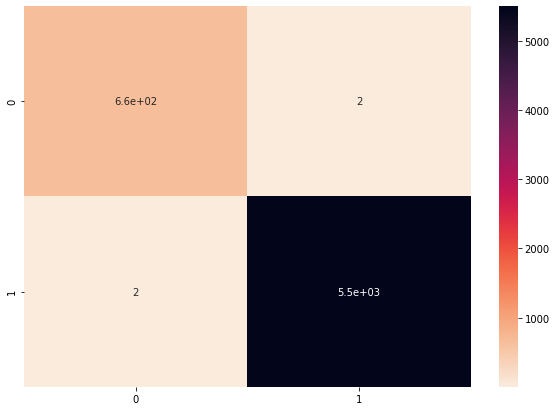

In [ ]:
minirocket_preds, minirocket_truths = minirocket_classifier(data='Wafer', mode='cpu', src='sktime')
evaluate_predictions(minirocket_preds, minirocket_truths)

After a mere **7,50 seconds** — including 1,3 seconds to load the data — _MINIROCKET_ features enabled the classifier to achieve **near-perfect performance** with only 5 of the 6.164 test samples classified incorrectly in the presence of a heavy class imbalance. With little to no optimizations for the dataset, features were extracted quickly to enable versatile classification of imbalanced datasets.

Unfortunately, the performance of the classifier cannot be attributed to a selection of _MINIROCKET_'s features as a feature cannot (currently) be linked to the kernel that enabled its calculation... This causes the feature transformation to **lack any explainability whatsoever**.

#### _tsfresh_ (min)

Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  6.45it/s]


  Configuration:
    data:      "Wafer" (univariate)
    features:  "min"
  Performance:
    test_acc:  0.8933
  Run time:
    total:     0:00:05.516722
    data:      0:00:01.452837
    training:  0:00:04.049162
    testing:   0:00:00.014723
  Detailed performance
    accuracy:          0.893251
    precision:         0.904659
    recall:            0.893251
    f1:                0.898919
    roc auc:           0.505263
    confusion matrix:


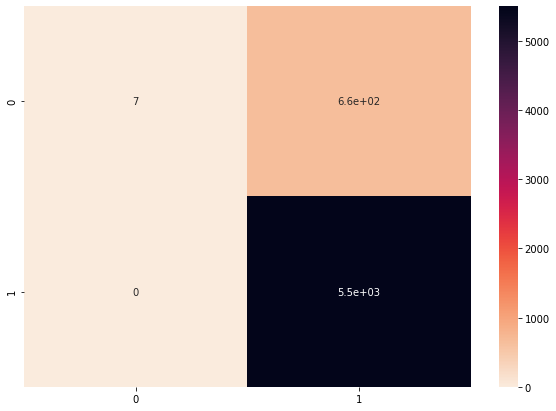

In [ ]:
tsfresh_min_preds, tsfresh_min_truths = tsfresh_classifier('Wafer', 'min')
evaluate_predictions(tsfresh_min_preds, tsfresh_min_truths)

While minimal _tsfresh_ feature extraction is just faster than _MINIROCKET_ feature transformation — clocking in at **just under 5,5 seconds** — it is clear that this configuration does not allow the classifier to distinguish between both target classes and causes it to **default to the majority class**.

#### *tsfresh* (efficient)

In [ ]:
if run_tsfresh_check:
    tsfresh_efficient_preds, tsfresh_efficient_truths = tsfresh_classifier('Wafer', 'efficient')
else:
    # Print manually "cached" tsfresh results
    print("""Feature Extraction: 100%|██████████| 20/20 [10:16<00:00, 30.81s/it]
Configuration:
data:      "Wafer" (univariate)
features:  "efficient"
Performance:
test_acc:  1
Run time:
    total:     0:10:37.877604
    data:      0:00:01.294506
    training:  0:10:36.538375
    testing:   0:00:00.044723
    """)

Feature Extraction: 100%|██████████| 20/20 [10:16<00:00, 30.81s/it]
Configuration:
data:      "Wafer" (univariate)
features:  "efficient"
Performance:
test_acc:  1
Run time:
    total:     0:10:37.877604
    data:      0:00:01.294506
    training:  0:10:36.538375
    testing:   0:00:00.044723
    


To achieve performance on par with _MINIROCKET_ (actually even achieving perfect performance), _tsfresh_'s efficient configuration required over 10 minutes — that is 600 seconds or about **70 times longer than _MINIROCKET_**.

While it does offer **perfect performance**, the increase in classification accuracy is only marginal (5 samples) and does thus not outweigh the exponential increase in run time. A bigger trade-off is that of explainability; whereas _MINIROCKET_ offers 10.000 features that cannot be traced back to the kernel that they originated from, _tsfresh_ features are **theoretical statistical measures from the data that offer (some) interpretability**; note that this is only a limited form of explainability, as the interpretation of, e.g., a time series' _5th Welch density coefficient_ may offer very little insights.

Since perfect performance could be achieved, running _tsfresh_ configured to extract all features is unnecessary as it would run even longer (though not much) with no accuracy increase.

#### _fft_/_stft_

  Configuration:
    data:  "Wafer" (univariate)
  Performance:
    test_acc:  0.9267
  Run time:
    total:     0:00:01.590737
    data:      0:00:01.464711
    training:  0:00:00.105057
    testing:   0:00:00.020969
  Detailed performance
    accuracy:          0.926671
    precision:         0.926045
    recall:            0.926671
    f1:                0.926358
    roc auc:           0.674030
    confusion matrix:


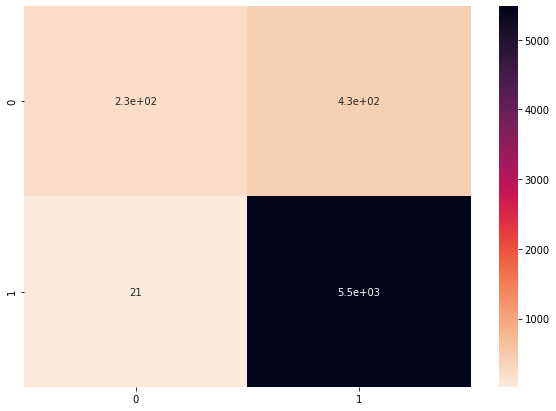

In [ ]:
fft_min_preds, fft_min_truths = fft_classifier('Wafer')
evaluate_predictions(fft_min_preds, fft_min_truths)

  Configuration:
    data:  "Wafer" (univariate)
  Performance:
    test_acc:  0.9966
  Run time:
    total:     0:00:01.884898
    data:      0:00:01.746312
    training:  0:00:00.122217
    testing:   0:00:00.016369
  Detailed performance
    accuracy:          0.996593
    precision:         0.996644
    recall:            0.996593
    f1:                0.996619
    roc auc:           0.995447
    confusion matrix:


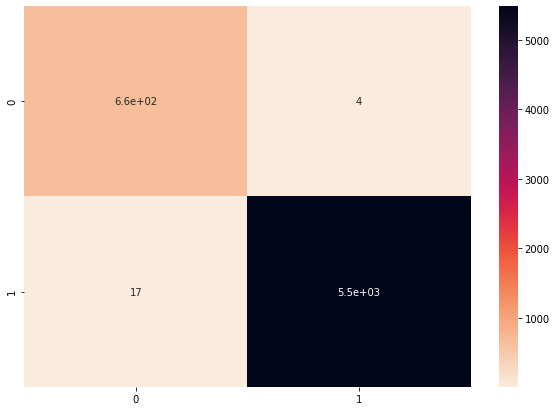

In [ ]:
stft_min_preds, stft_min_truths = stft_classifier('Wafer')
evaluate_predictions(stft_min_preds, stft_min_truths)

While Fourier transformed features are also quick to calculate (and can even extract features for large datasets in a matter of seconds), **classification performance when learning with these features is generally worse** than with _MINIROCKET_ features. Additionally, while inherently interpretable, depending on the use case Fourier transformed features **may or may not offer additional insights into how predictions are made**.

<a name="experiment-2"></a>
### Experiment 2: *MINIROCKET* execution on CPU vs. GPU
The second experiment compares MINIROCKET implementations for CPU and GPU execution in terms of their execution speeds on so-called _large sized_ datasets (\> 10.000 samples as defined by the authors) and checkes their performances for any discrepancies in accuracy. For this, the UEA & UCR Time Series Classification Repository [_ElectricDevices_](http://www.timeseriesclassification.com/description.php?Dataset=ElectricDevices) dataset was used.

- **Train size**: 8926
- **Test size**: 7711
- **Sample length**: 96
- **Number of classes**: 7 (types of electric devices)

The intention of this dataset was to collect behavioural data about how consumers use electricity within the home to help reduce the UK's carbon footprint. The data contains readings from 251 households, sampled in two-minute intervals over a month.

#### CPU
A CPU implementation is provided by both the [_sktime_](https://github.com/alan-turing-institute/sktime) (specialized time series algorithms and scikit-learn compatible tools to build, tune and validate time series models for multiple learning problems) and [_tsai_](https://github.com/timeseriesAI/tsai) (state-of-the-art deep learning for time series and sequence modeling, built on top of _Pytorch_ and _fastai_) packages. Experiments showed that the _sktime_ implementation was increasingly faster for growing dataset sizes and will thus be preferred here.

Running MINIROCKET classifier...
  Data loading:   0:00:02.512973
  Model training: 0:03:06.543910
  Model testing:  0:00:04.175349
  Configuration:
    data:  "ElectricDevices" (univariate)
    mode:  "cpu"
    src:   "sktime"
  Performance:
    test_acc:  0.7401
  Run time:
    total:     0:03:13.232232
    data:      0:00:02.512973
    training:  0:03:06.543910
    testing:   0:00:04.175349
  Detailed performance
    accuracy:          0.740112
    precision:         0.739217
    recall:            0.740112
    f1:                0.739664
    roc auc:           0.841407
    confusion matrix:


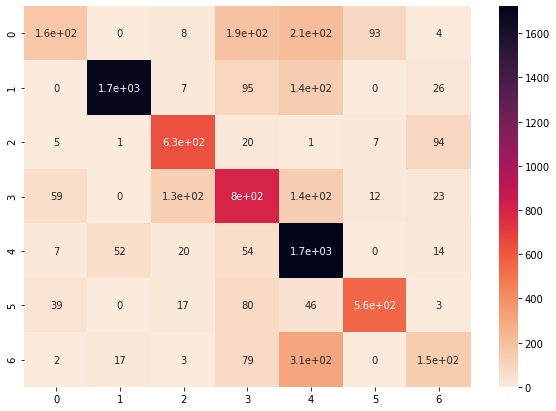

In [ ]:
cpu_preds, cpu_truths = minirocket_classifier(data='ElectricDevices', mode='cpu', src='sktime')
evaluate_predictions(cpu_preds, cpu_truths)

While still very manageble, _MINIROCKET_ on CPU for large(r) datasets takes around 3 minutes and 13 seconds: just above 3 minutes for training and about 4 seconds for inference.

#### GPU
The [_tsai_](https://github.com/timeseriesAI/tsai) package also provides the GPU implementation of _MINIROCKET_.

Running MINIROCKET classifier...
  Data loading:   0:00:02.480717
Finding optimal learning rate


epoch,train_loss,valid_loss,accuracy,time
0,1.014210,1.071049,0.659707,00:01
1,0.730426,1.029928,0.680197,00:01
2,0.576631,1.077388,0.679030,00:01
3,0.483152,1.043403,0.709636,00:01
4,0.443674,1.058951,0.705745,00:01
5,0.400666,0.982115,0.741408,00:01
6,0.386302,1.058740,0.702762,00:01
7,0.353656,1.119221,0.707561,00:01
8,0.345954,1.404489,0.628583,00:01
9,0.356524,1.283165,0.687719,00:01


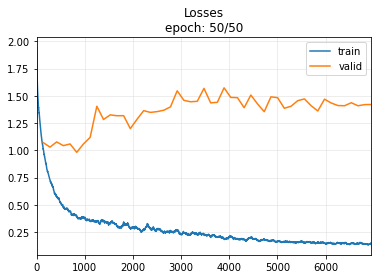

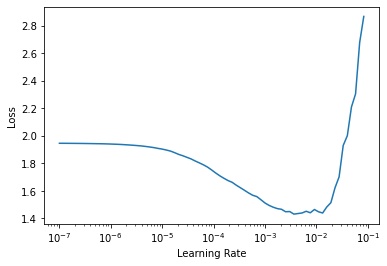

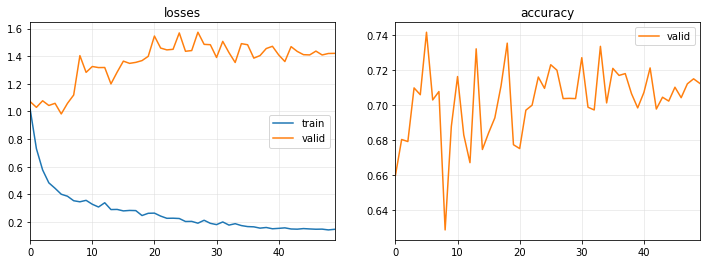

  Model training: 0:01:22.202834


  Model testing:  0:00:00.538189
  Configuration:
    data:  "ElectricDevices" (univariate)
    mode:  "gpu"
    src:   "tsai"
  Performance:
    test_acc:  0.7122
  Run time:
    total:     0:01:25.221740
    data:      0:00:02.480717
    training:  0:01:22.202834
    testing:   0:00:00.538189
  Detailed performance
    accuracy:          0.712229
    precision:         0.709947
    recall:            0.712229
    f1:                0.711086
    roc auc:           0.825029
    confusion matrix:


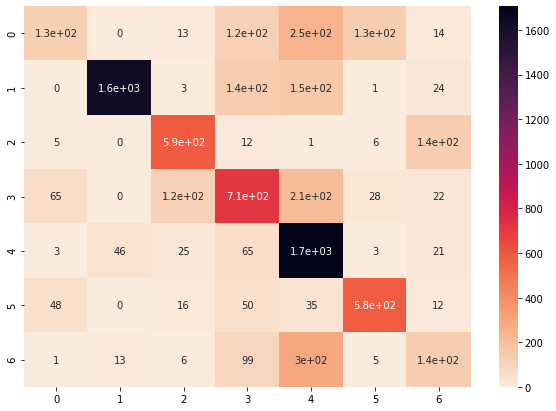

In [ ]:
gpu_preds, gpu_truths = minirocket_classifier(data='ElectricDevices', mode='gpu', src='tsai')
evaluate_predictions(gpu_preds, gpu_truths)

As expected, GPU _MINIROCKET_ accuracy is in the same ball-park as its CPU counterpart (and discrepancies can thus be allotted randomness in the kernel selection) and both implementations seem to enable the same classification errors when looking at the confusion matrix. However, the **runtime is significantly shorter** — running on GPU took less than half the training time and about an eight of the inference time!

<a name='takeaways'></a>
## Take-aways
Based on the results of the two experiments in this notebook, the following guidelines can be considered:
- Features transformed with **_MINIROCKET_ enable performance on par with the current way of working** (namely 'efficient'/'all' _tsfresh_ feature extraction).
- **_MINIROCKET_ significantly reduces the runtime required for a similar accuracy** as _tsfresh_. Whereas runtimes of _tsfresh_ increase exponentially for growing dataset sizes and become infeasible quite fast, _MINIROCKET_ runtimes stay manageble even for large datasets (of datasets with long samples) by using its GPU implementation.
- Though slower and somewhat less interpretable, _MINIROCKET_ features generally **enable a classifier to be more performant than when trained with Fourier features**.
- **_MINIROCKET_'s GPU implementation is useful for datasets with over 10.000 samples**; for smaller datasets use its CPU implementation for the minimal runtime.
- The above _MINIROCKET_ perks come **at the cost of model interpretability**; its features cannot be linked back to the kernels that they originated from and can thus not be explained. On the contrary, _tsfresh_ features are theoretical statistical measures that can be interpreted (but can still offer very little insights).

Considering the above guidelines, _MINIROCKET_ feature extraction thus offers a great way to quickly establish a baseline performance for a new time series classification problem before delving into more time consuming or more interpretable methods. Additionally, it can be used to obtain state-of-the-art performance with minimal effort if explainability is not required.